In [1]:
import pandas as pd

# Load the CSV file
data_df = pd.read_csv(r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\train.csv')

# Map the diagnosis to categorical labels
diagnosis_mapping = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}
data_df['label'] = data_df['diagnosis'].map(diagnosis_mapping)

print(data_df.head())


        id_code  diagnosis           label
0  000c1434d8d7          2        Moderate
1  001639a390f0          4  Proliferate_DR
2  0024cdab0c1e          1            Mild
3  002c21358ce6          0           No_DR
4  005b95c28852          0           No_DR


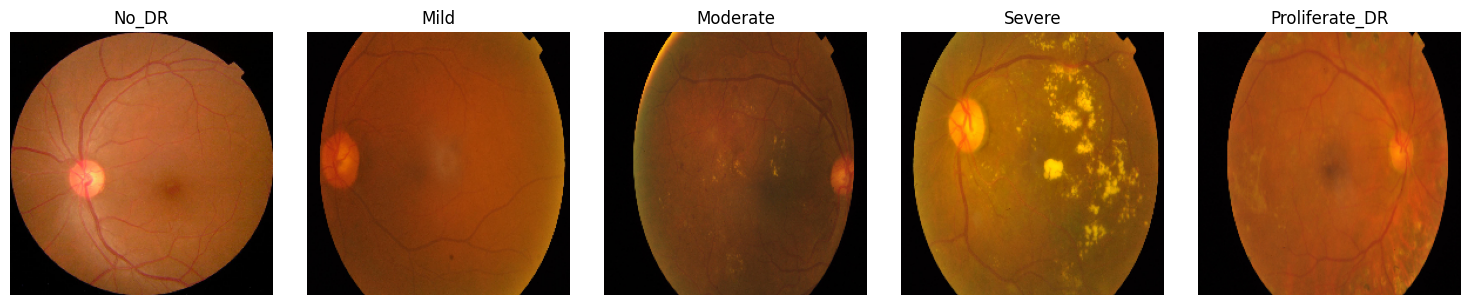

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def load_and_display_samples(image_directory):
    diagnosis_mapping = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    axes = axes.flatten()
    
    for idx, (diagnosis, folder_name) in enumerate(diagnosis_mapping.items()):
        folder_path = os.path.join(image_directory, folder_name)
        sample_image_file = os.listdir(folder_path)[0]  # Take the first image in the folder
        image_path = os.path.join(folder_path, sample_image_file)
        image = Image.open(image_path)
        
        axes[idx].imshow(image)
        axes[idx].axis('off')
        axes[idx].set_title(folder_name)
    
    plt.tight_layout()
    plt.show()

# Replace this path with the correct path to your 'colored_images' directory
image_directory = r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images'
load_and_display_samples(image_directory)


In [16]:
from PIL import Image
import numpy as np
from tensorflow.keras.utils import to_categorical
import os

def generate_data(dataframe, directory, batch_size, mode='train'):
    diagnosis_mapping = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}
    while True:
        for start in range(0, len(dataframe), batch_size):
            end = min(start + batch_size, len(dataframe))
            batch_data = dataframe.iloc[start:end]
            batch_images = []
            batch_labels = []
            for _, row in batch_data.iterrows():
                folder_name = diagnosis_mapping[row['diagnosis']]
                img_path = os.path.join(directory, folder_name, row['id_code'] + '.png')
                if not os.path.exists(img_path):
                    continue  # Skip missing images
                image = Image.open(img_path).resize((224, 224))
                image = np.array(image) / 255.0
                batch_images.append(image)
                batch_labels.append(row['diagnosis'])  # Append the diagnosis directly
            if batch_images:  # Check if there are any images in the batch
                yield np.array(batch_images), np.array(batch_labels)


In [13]:
# Assuming you have a DataFrame 'train_df' prepared from your CSV file
train_df = pd.read_csv(r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\train.csv')

# Example usage of the generator
test_gen = generate_data(train_df, image_directory, 32)
images, labels = next(test_gen)
print("Batch Images Shape:", images.shape)
print("Batch Labels Shape:", labels.shape)


Batch Images Shape: (32, 224, 224, 3)
Batch Labels Shape: (32, 5)


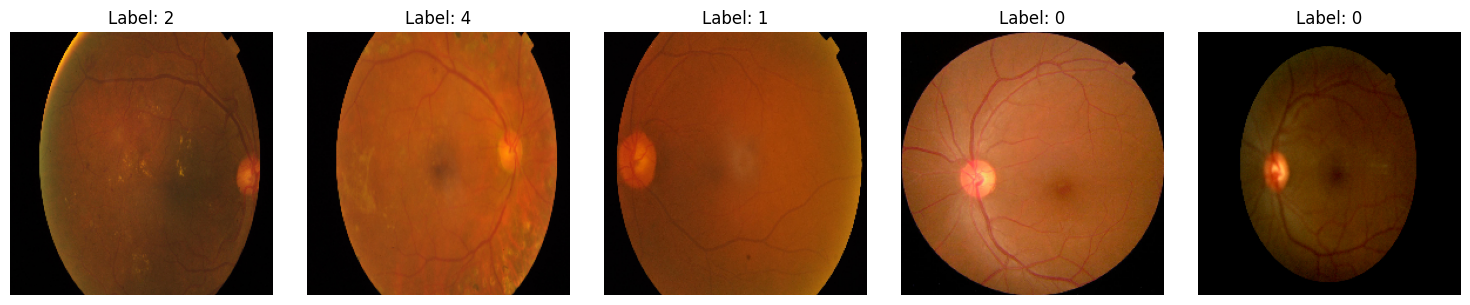

In [17]:
# Initialize the generator
train_generator = generate_data(train_df, image_directory, batch_size=5)  # Smaller batch size for display

# Generate one batch of data
images, labels = next(train_generator)

# Display the images and their labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f'Label: {labels[i]}')  # Display numerical label

plt.tight_layout()
plt.show()

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 classes for diabetic retinopathy severity
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


C:\Users\spars\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set training parameters
epochs = 10
batch_size = 32

# Prepare callbacks for saving the model and early stopping
checkpoint = ModelCheckpoint('model_best.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    generate_data(train_df, image_directory, batch_size),
    steps_per_epoch=len(train_df) // batch_size,
    validation_data=generate_data(val_df, image_directory, batch_size),
    validation_steps=len(val_df) // batch_size,
    epochs=epochs,
    callbacks=[checkpoint, early_stop]
)



Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5940 - loss: 1.1533 - val_accuracy: 0.7244 - val_loss: 0.7853
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 91s 802ms/step - accuracy: 0.6968 - loss: 0.8162 - val_accuracy: 0.7375 - val_loss: 0.7688
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 94s 825ms/step - accuracy: 0.7157 - loss: 0.7766 - val_accuracy: 0.7304 - val_loss: 0.7689
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 95s 835ms/step - accuracy: 0.7181 - loss: 0.7537 - val_accuracy: 0.7404 - val_loss: 0.7146
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 93s 813ms/step - accuracy: 0.7140 - loss: 0.7417 - val_accuracy: 0.7290 - val_loss: 0.7213
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 85s 745ms/step - accuracy: 0.7208 - loss: 0.7434 - val_accuracy: 0.7318 - val_loss: 0.7076
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 85s 745ms/step - accuracy: 0.7328 - loss: 0.7134 - val_accuracy: 0.7475 - val_loss: 0.6942
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 85s 747ms/step - accuracy: 0.7371 - loss: 0.7

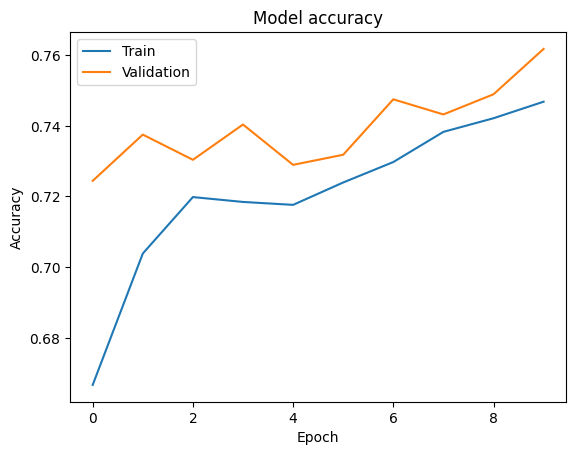

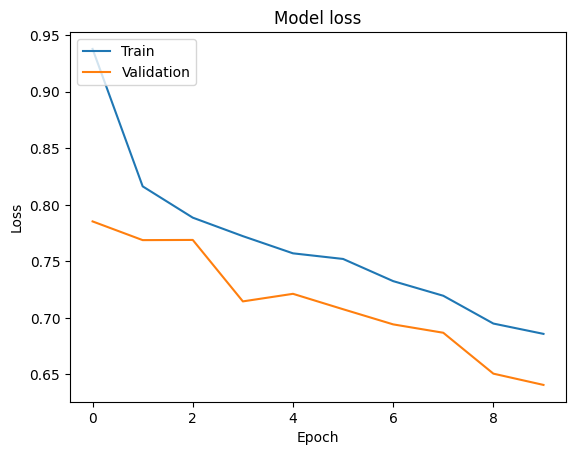

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [23]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('model_best.keras')


In [25]:
def generate_data_for_prediction(dataframe, directory, batch_size):
    while True:
        for start in range(0, len(dataframe), batch_size):
            end = min(start + batch_size, len(dataframe))
            batch_data = dataframe.iloc[start:end]
            batch_images = []
            for _, row in batch_data.iterrows():
                folder_name = diagnosis_mapping[row['diagnosis']]
                img_path = os.path.join(directory, folder_name, row['id_code'] + '.png')
                if not os.path.exists(img_path):
                    continue  # Skip missing images
                image = Image.open(img_path).resize((224, 224))
                image = np.array(image) / 255.0
                batch_images.append(image)
            if batch_images:
                yield np.array(batch_images)


In [ ]:
# Calculate the number of steps to exhaust the data generator
steps = len(test_df) // 32

# Make predictions
predictions = model.predict(test_gen, steps=steps)

# Convert predictions to labels
predicted_labels = np.argmax(predictions, axis=1)


In [29]:
from PIL import Image
import numpy as np

def process_image(image_path, target_size=(224, 224)):
    # Load the image file
    image = Image.open(image_path)
    # Resize image to match the model's expected input dimensions
    image = image.resize(target_size)
    # Convert the image to a numpy array
    image_array = np.array(image)
    # Scale the image pixels by 255 (or use another scaling factor depending on your model's training)
    image_array = image_array / 255.0
    # Expand dimensions to fit model input (model expects batch, height, width, channels)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array


In [34]:
image_path = r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images\Mild\0a61bddab956.png'
processed_image = process_image(image_path)


In [35]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('model_best.keras')

# Make prediction
prediction = model.predict(processed_image)

# Convert prediction array to a specific label index
predicted_label = np.argmax(prediction, axis=1)[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


In [36]:
label_mapping = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}
predicted_diagnosis = label_mapping[predicted_label]
print("Predicted Diagnosis:", predicted_diagnosis)


Predicted Diagnosis: Mild


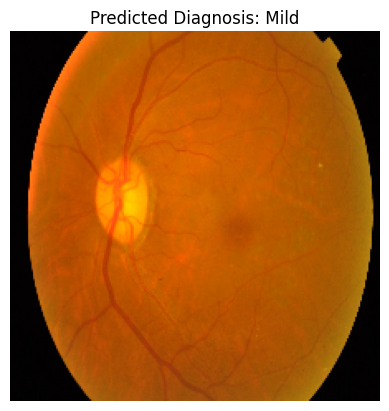

In [37]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(np.squeeze(processed_image))  # Squeeze to remove the batch dimension
plt.axis('off')  # No axes for cleaner presentation
plt.title(f"Predicted Diagnosis: {predicted_diagnosis}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
True Label: 2 (Moderate), Predicted Label: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
True Label: 4 (Proliferate_DR), Predicted Label: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True Label: 1 (Mild), Predicted Label: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
True Label: 0 (No_DR), Predicted Label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
True Label: 0 (No_DR), Predicted Label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
True Label: 4 (Proliferate_DR), Predicted Label: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
True Label: 0 (No_DR), Predicted Label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
True Label: 2 (Moderate), Predicted Label: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
True Label: 2 (Moderate), Predicted Label: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
True Label: 1 (Mild), Predicted Label: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
True Label: 3 (Severe), Predicted Label: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
True Label: 1 (Mild), Predicted Label: 2
1/1 ━━━━━━━━━━━

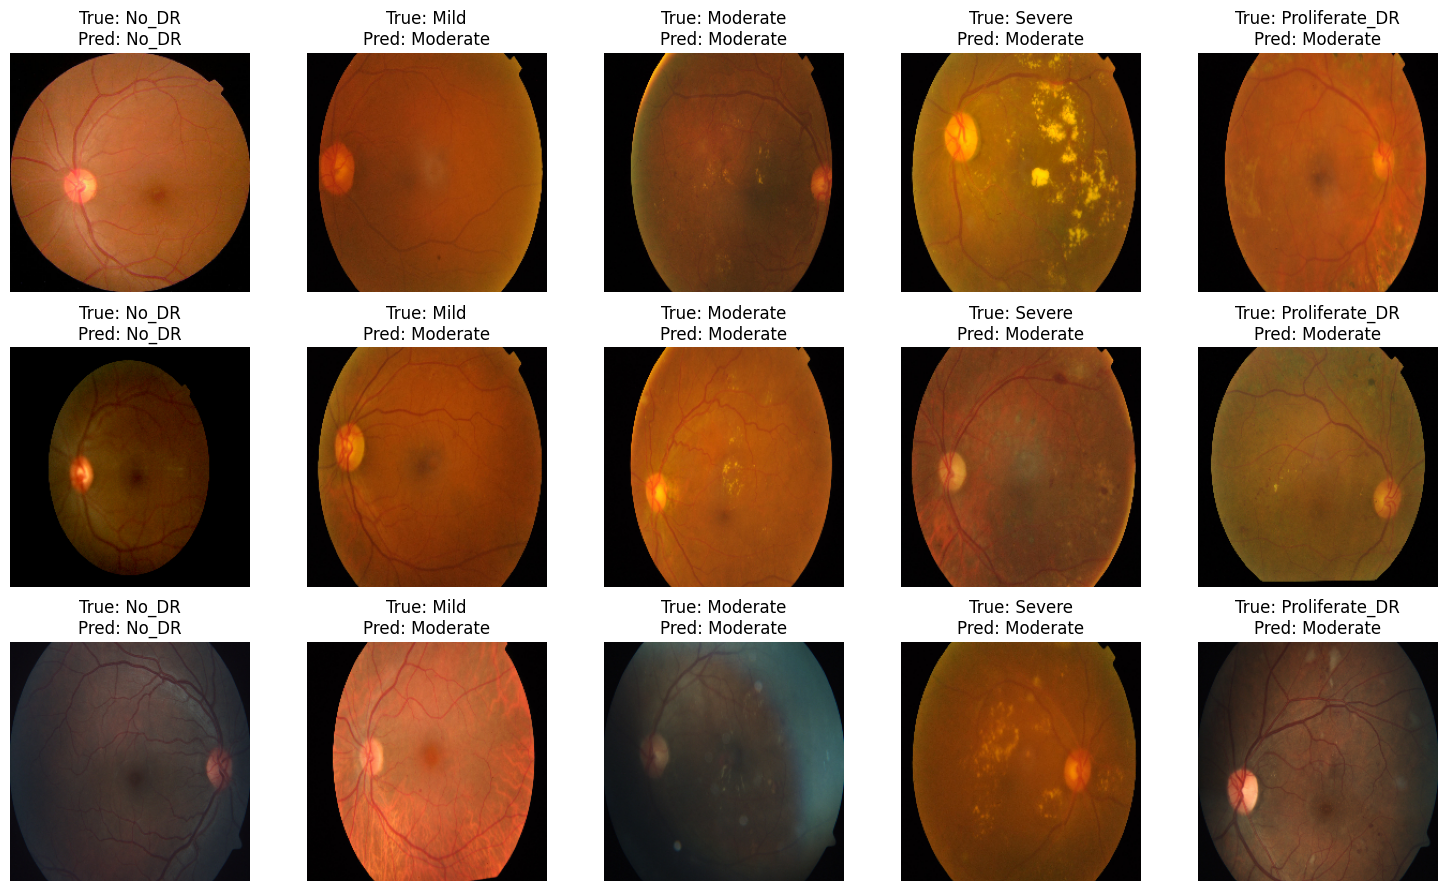

In [41]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model
model = load_model('model_best.keras')

# Define the function to generate and display predictions for a few samples from each subfolder
def generate_and_display_predictions(dataframe, directory, num_samples=3):
    diagnosis_mapping = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}
    sample_count = {k: 0 for k in diagnosis_mapping.keys()}  # Track samples printed per subfolder
    fig, axes = plt.subplots(num_samples, len(diagnosis_mapping), figsize=(15, num_samples * 3))  # Prepare figure
    
    # Iterate through the dataset
    for idx, (index, row) in enumerate(dataframe.iterrows()):
        folder_name = diagnosis_mapping[row['diagnosis']]
        if sample_count[row['diagnosis']] >= num_samples:
            continue  # Skip if we've printed enough samples for this label
        
        img_path = os.path.join(directory, folder_name, row['id_code'] + '.png')
        if not os.path.exists(img_path):
            continue  # Skip missing images
        
        # Process the image
        image = Image.open(img_path).resize((224, 224))
        image_array = np.array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        
        # Make a prediction
        prediction = model.predict(image_array)
        predicted_label = np.argmax(prediction, axis=1)[0]  # Get the predicted class
        
        # Print true and predicted label (for logging)
        print(f"True Label: {row['diagnosis']} ({folder_name}), Predicted Label: {predicted_label}")
        
        # Display the image with true and predicted labels
        ax = axes[sample_count[row['diagnosis']], row['diagnosis']]
        ax.imshow(np.array(image))
        ax.axis('off')
        ax.set_title(f"True: {folder_name}\nPred: {diagnosis_mapping[predicted_label]}")
        
        # Update sample count
        sample_count[row['diagnosis']] += 1
        
        # Stop when we've printed enough samples for each subfolder
        if all([count >= num_samples for count in sample_count.values()]):
            break
    
    plt.tight_layout()
    plt.show()

# Run the function to display 3 samples from each subfolder
generate_and_display_predictions(train_df, image_directory, num_samples=3)


In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)  # Rescaling pixel values

# Assuming your images are stored in a directory structure
train_gen = datagen.flow_from_directory(
    r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images',  # Directory where training images are stored
    target_size=(224, 224),  # Resize images to 224x224 for ResNet
    batch_size=32,
    class_mode='sparse'  # For sparse categorical labels
)


Found 3662 images belonging to 5 classes.


In [60]:
# Extract features for your dataset
features = feature_extractor.predict(train_gen, steps=len(train_gen), verbose=1)

print(f"Feature Shape: {features.shape}")





C:\Users\spars\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step
Feature Shape: (3662, 2048)


In [65]:
import pennylane as qml
from pennylane import numpy as np

# Set up a PennyLane device
n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Create random weights for the quantum circuit (trainable in principle)
n_layers = 5
weights = np.random.normal(size=(n_layers, n_qubits, 3))

# Apply quantum circuit to the first n_qubits features of each image
quantum_output = []
for feature in features:
    # Use only the first n_qubits features
    quantum_result = quantum_circuit(feature[:n_qubits], weights)
    quantum_output.append(quantum_result)

quantum_output = np.array(quantum_output)
print(f"Quantum Output Shape: {quantum_output.shape}")


Quantum Output Shape: (3662, 4)


In [63]:
# Assuming train_gen is your ImageDataGenerator
y_labels = train_gen.classes  # This extracts the true labels for your dataset

# Verify the shape of labels
print(f"Labels Shape: {y_labels.shape}")


Labels Shape: (3662,)


In [66]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# Assuming you have labels associated with your data (e.g., y_labels)
# Replace `y_labels` with your actual labels from the dataset

# Split quantum output into train/test sets
X_train, X_test, y_train, y_test = train_test_split(quantum_output, y_labels, test_size=0.2, random_state=42)

# Build a simple classifier
classifier = Sequential([
    Dense(64, activation='relu', input_shape=(n_qubits,)),
    Dense(5, activation='softmax')  # Assuming 5 classes for the diabetic retinopathy classification
])

# Compile the classifier
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
classifier.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10


C:\Users\spars\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3719 - loss: 1.5046 - val_accuracy: 0.4666 - val_loss: 1.3483
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5125 - loss: 1.2746 - val_accuracy: 0.4666 - val_loss: 1.3423
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5054 - loss: 1.2732 - val_accuracy: 0.4666 - val_loss: 1.3428
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5036 - loss: 1.2849 - val_accuracy: 0.4666 - val_loss: 1.3453
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4957 - loss: 1.2867 - val_accuracy: 0.4666 - val_loss: 1.3444
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4884 - loss: 1.3019 - val_accuracy: 0.4666 - val_loss: 1.3476
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5169 - loss: 1.2656 - val_accuracy: 0.4666 - val_loss: 1.3422
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4951 - loss: 1.2669 - val_accuracy: 0.4666 - val_loss: 1.3432
Epo